<a href="https://colab.research.google.com/github/putricha/college-machine-learning/blob/main/ML_UTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama Anggota Kelompok
1. Ahmad Taufiq Hidayatulloh - 2241720207
2. Lucky Kurniawan Langoday - 2241720168
3. Putri Norchasana - 2241720036
4. Raffy Jamil Octavialdy - 2241720082

# Download Dataset From Kaggle

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raffyjo","key":"8a41316a144bd74e46074ad1d84f1e4a"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset  Mobile Device Usage and User Behavior Dataset        11KB  2024-09-28 20:21:12          14055        305  1.0              
valakhorasani/gym-members-exercise-dataset                   Gym Members Exercise Dataset                         22KB  2024-10-06 11:27:38           7441        117  1.0              
yusufdelikkaya/datascience-salaries-2024                     Data Science Salaries 2024                           69KB  2024-10-23 18:39:50           1141         28  0.88235295       
lainguyn123/student-performance-factors                      Student Perfor

In [ ]:
!kaggle datasets download -d 'ntl0601/casia-webface'

Dataset URL: https://www.kaggle.com/datasets/ntl0601/casia-webface
License(s): unknown
 99% 2.52G/2.53G [00:26<00:00, 164MB/s]
100% 2.53G/2.53G [00:27<00:00, 101MB/s]


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile('/content/casia-webface.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Preparation

Memasukkan library yang dibutuhkan.

In [ ]:
# Import necessary libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load Data

In [ ]:
import os
import shutil

# Path to your dataset
path = '/content/casia-webface'

# Step 1: Filter classes with more than 500 images
filtered_classes = []

for class_dir in os.listdir(path):
    class_path = os.path.join(path, class_dir)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        if num_images > 500:  # Check for more than 500 images
            filtered_classes.append(class_dir)

print(f"Classes with more than 500 images: {len(filtered_classes)}")

# Step 2: Create a filtered dataset directory
filtered_dataset_path = '/content/filtered5_casia_webface'

os.makedirs(filtered_dataset_path, exist_ok=True)

for class_dir in filtered_classes:
    src_class_dir = os.path.join(path, class_dir)
    dest_class_dir = os.path.join(filtered_dataset_path, class_dir)
    os.makedirs(dest_class_dir, exist_ok=True)

    # Step 3: Copy all images from the original dataset to the filtered dataset
    for img_file in os.listdir(src_class_dir):
        src_img = os.path.join(src_class_dir, img_file)
        dest_img = os.path.join(dest_class_dir, img_file)
        os.link(src_img, dest_img)  # Use os.link for fast linking instead of copying

print("Filtering completed.")

Classes with more than 500 images: 11
Filtering completed.


# Preprocessing

1. Definisi Fungsi:
  - Fungsi `load_data` menerima jalur direktori `(dataset_dir)` sebagai input, yang berisi subdirektori untuk setiap kelas gambar.

2. Inisialisasi Fitur dan Label:
  - Dua daftar kosong, `features` dan `labels`, diinisialisasi untuk menyimpan fitur HOG dan label yang sesuai untuk setiap gambar.

3. Loop Melalui Kelas:
  - Fungsi ini mengiterasi melalui setiap direktori kelas yang ditemukan di `dataset_dir`.
  - Untuk setiap kelas, jalur direktori dibangun dan diperiksa apakah itu adalah direktori.

4. Proses Gambar:
  - Di dalam setiap direktori kelas, loop dijalankan untuk semua file gambar:
    - Gambar dibaca menggunakan OpenCV `(cv2.imread)`.
    - Gambar diubah ukurannya menjadi 128x128 piksel untuk menstandarkan ukuran input bagi model.
    - Gambar diubah menjadi grayscale, yang sering kali bermanfaat untuk ekstraksi fitur karena HOG lebih fokus pada gradien.

5. Ekstraksi Fitur HOG:
  - Fitur HOG diekstrak dari gambar grayscale menggunakan fungsi `hog`. Beberapa parameter penting:
    - `orientations=9`: Jumlah bin orientasi untuk gradien.
    - `pixels_per_cell=(8, 8)`: Ukuran sel tempat histogram dihitung.
    - `cells_per_block=(2, 2)`: Jumlah sel dalam setiap blok untuk normalisasi.
  - Fitur yang diekstrak ditambahkan ke daftar `features`, dan nama kelas yang sesuai ditambahkan ke daftar `labels`.

6. Mengembalikan Fitur dan Label:
  - Setelah memproses semua gambar, fungsi ini mengembalikan fitur dan label dalam bentuk array NumPy.

7. Pengkodean Label:
  - Label (nama kelas) diubah menjadi nilai integer menggunakan `LabelEncoder`. Ini adalah langkah pra-pemrosesan standar untuk tugas klasifikasi.

8. Konversi Kategorikal:
  - Label yang telah dienkode kemudian diubah menjadi format kategorikal yang sesuai untuk pelatihan jaringan saraf menggunakan `to_categorical`.

In [ ]:
def load_data(dataset_dir):
    features = []
    labels = []

    # Loop through each class directory
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)

        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)

                # Read the image
                image = cv2.imread(img_path)
                image = cv2.resize(image, (128, 128))  # Resize to match ANN input size

                # Convert to grayscale
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                # Extract HOG features (remove multichannel argument)
                hog_features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                                   cells_per_block=(2, 2), visualize=False)

                features.append(hog_features)
                labels.append(class_name)

    return np.array(features), np.array(labels)

# Load the dataset and extract features
dataset_dir = '/content/filtered5_casia_webface'  # Update with your dataset path
X, y = load_data(dataset_dir)

# Encode labels to integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert labels to categorical
y_categorical = to_categorical(y_encoded)

Pembagian dataset menjadi dua subset: satu untuk pelatihan (`X_train`, `y_train`) dan satu untuk validasi (`X_val`, `y_val`)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.1, random_state=42)

# Build Model

Ringkasan Struktur Model ANN
- Total Layer: 4 (2 Dense dan 2 Dropout)
- Fungsi Aktivasi: ReLU untuk layer tersembunyi dan Softmax untuk layer output.
- Dropout: Mengurangi risiko overfitting dengan menonaktifkan neuron secara acak.

In [ ]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_categorical.shape[1], activation='softmax'))  # Number of classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Melatih model dengan data pelatihan sambil memantau akurasi pada data validasi untuk memastikan model belajar dengan baik.

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1604 - loss: 2.4515 - val_accuracy: 0.4897 - val_loss: 1.7294
Epoch 2/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3822 - loss: 1.7309 - val_accuracy: 0.6850 - val_loss: 1.1954
Epoch 3/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4846 - loss: 1.4446 - val_accuracy: 0.7400 - val_loss: 0.9260
Epoch 4/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5491 - loss: 1.2577 - val_accuracy: 0.7854 - val_loss: 0.8596
Epoch 5/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5652 - loss: 1.1939 - val_accuracy: 0.7827 - val_loss: 0.8359
Epoch 6/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5945 - loss: 1.1011 - val_accuracy: 0.7923 - val_loss: 0.7664
Epoch 7/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6006 - loss: 1.0780 - val_accuracy: 0.7882 - val_loss: 0.7121
Epoch 8/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6203 - loss: 1.0173 - val_accuracy: 0

# Evaluation

Evaluasi model dan memvisualisasikan hasil pelatihan.

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8090 - loss: 0.6245 
Validation Accuracy: 80.19%


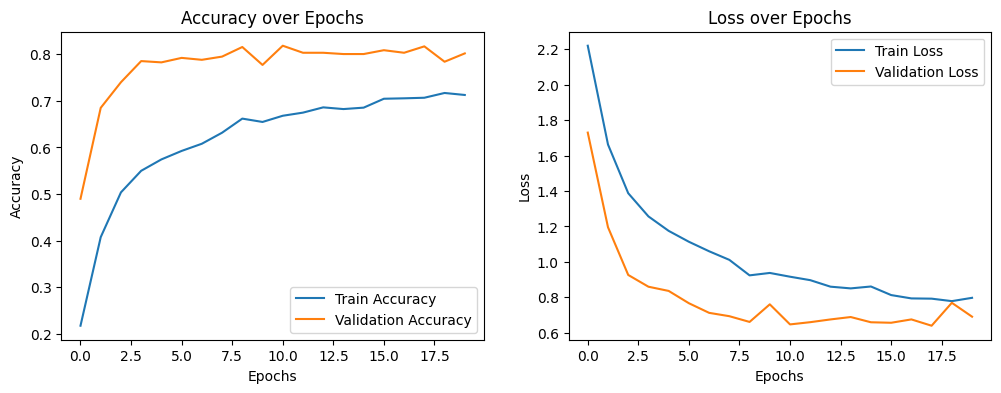

In [ ]:
# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
!jupyter nbconvert --to html /content/ML_UTS.ipynb

[NbConvertApp] Converting notebook /content/ML_UTS.ipynb to html
[NbConvertApp] Writing 703824 bytes to /content/ML_UTS.html
